In [49]:
pip install mne

In [50]:
import os

import mne
from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs

sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = os.path.join(
    sample_data_folder, "MEG", "sample", "sample_audvis_filt-0-40_raw.fif"
)
raw = mne.io.read_raw_fif(sample_data_raw_file)

# Here we'll crop to 60 seconds and drop gradiometer channels for speed
raw.crop(tmax=60.0).pick(picks=["mag", "eeg", "stim", "eog"])
raw.load_data()

Opening raw data file /root/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 9009  =      0.000 ...    59.999 secs...


<Raw | sample_audvis_filt-0-40_raw.fif, 172 x 9010 (60.0 s), ~14.9 MB, data loaded>

# As long as these various source signals are statistically independent and non-gaussian, it is usually possible to separate the sources using ICA, and then re-construct the sensor signals after excluding the sources that are unwanted.

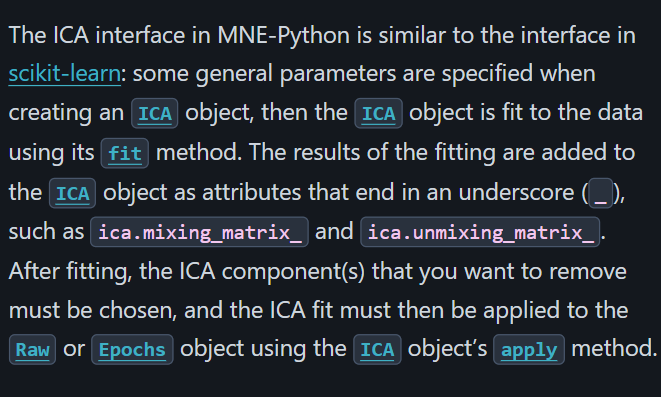

## Whitening :-
this means that the power of the signal is distributed uniformly across all frequencies, effectively removing correlations between different frequency components. Whitening is used to improve the performance of various signal processing techniques by making the statistical properties of the signal more uniform.

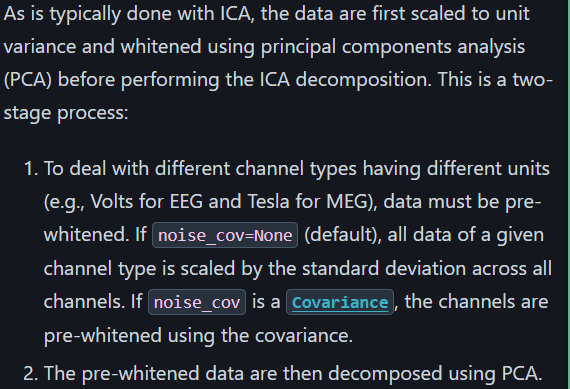

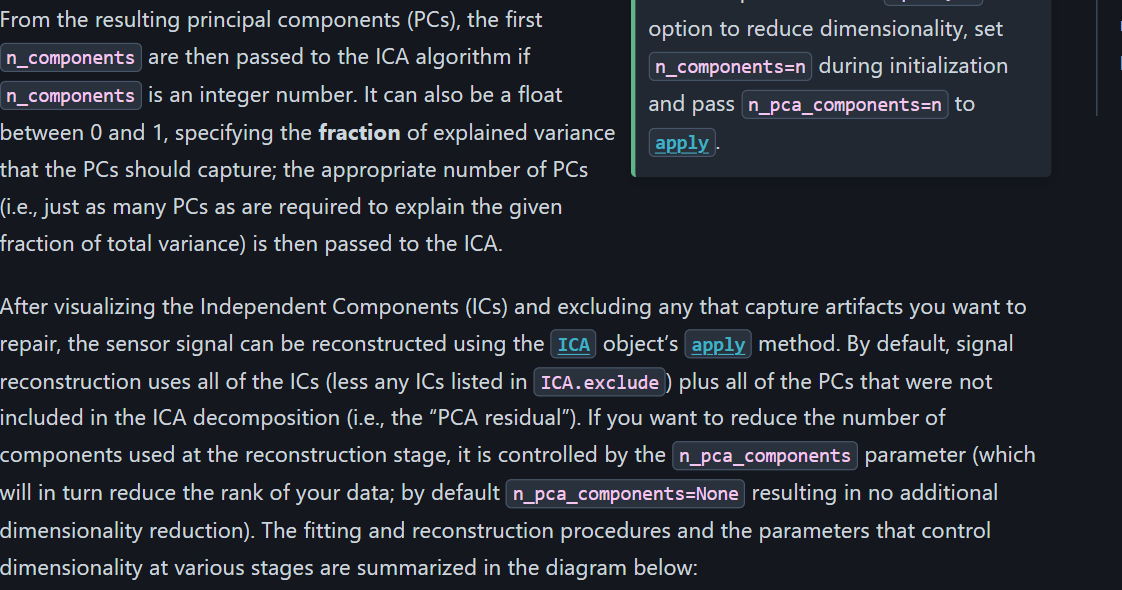

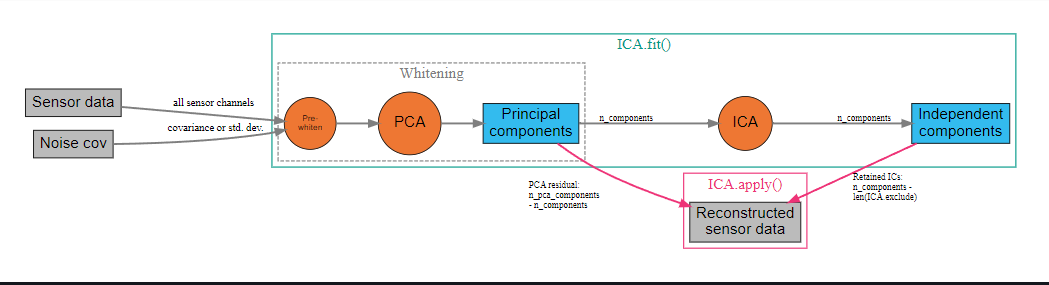

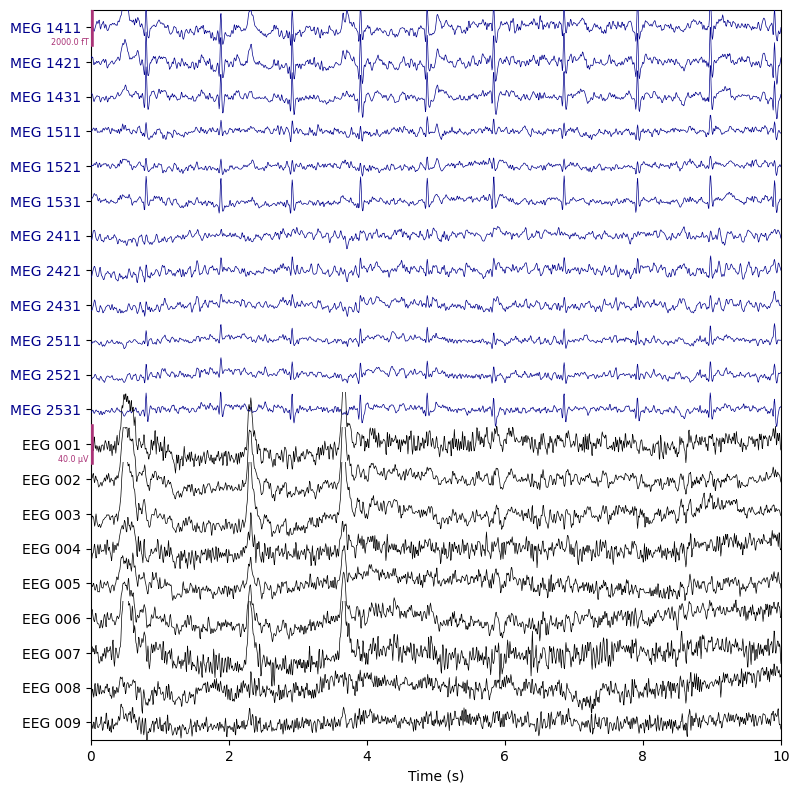

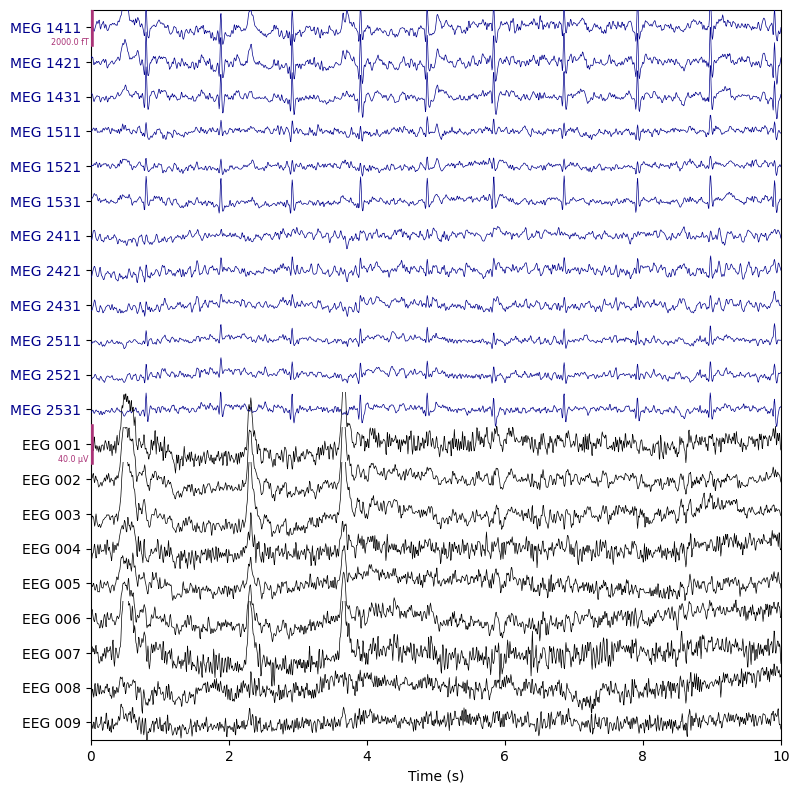

In [51]:
# pick some channels that clearly show heartbeats and blinks
regexp = r"(MEG [12][45][123]1|EEG 00.)"
artifact_picks = mne.pick_channels_regexp(raw.ch_names, regexp=regexp)
raw.plot(order=artifact_picks, n_channels=len(artifact_picks), show_scrollbars=False)

We can get a summary of how the ocular artifact manifests across each channel type using create_eog_epochs

Using EOG channel: EOG 061
EOG channel index for this subject is: [171]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EOG 061 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1502 samples (10.003 s)

Now detecting blinks and generating corresponding events
Found 10 significant peaks
Number of EOG events detected: 10
Not setting metadata
10 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 4)
Using data from preloaded Raw for 10 events and 151 original time points 

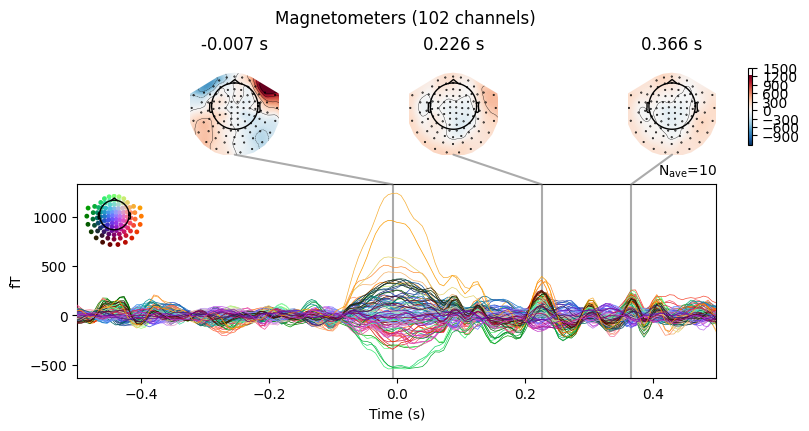

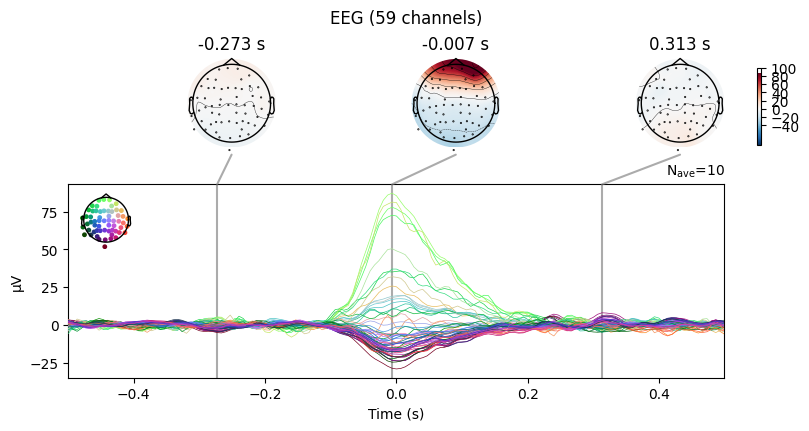

[<Figure size 800x420 with 6 Axes>, <Figure size 800x420 with 6 Axes>]

In [52]:
eog_evoked=create_eog_epochs(raw).average()
eog_evoked.apply_baseline(baseline=(None,-0.2))
eog_evoked.plot_joint()

Now we'll do the same for the heartbeat artificats,using create_ecg_epochs

Reconstructing ECG signal from Magnetometers
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 1502 samples (10.003 s)

Number of ECG events detected : 59 (average pulse 58 / min.)
Not setting metadata
59 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 4)
Using data from preloaded Raw for 59 events and 151 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 4)
4 projection items activated
SSP projectors applied...


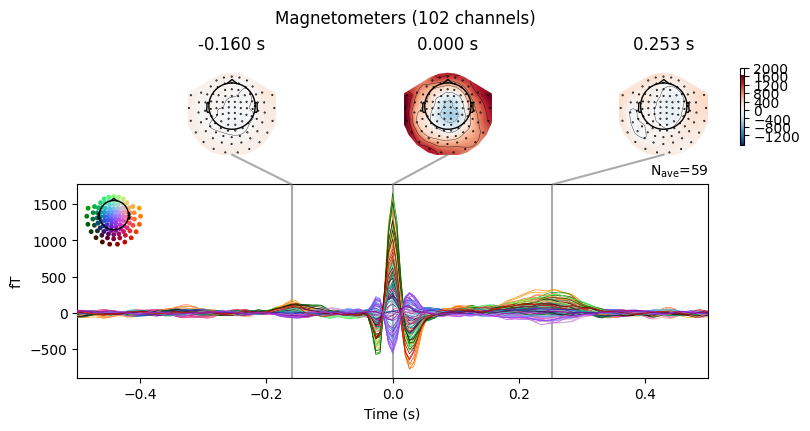

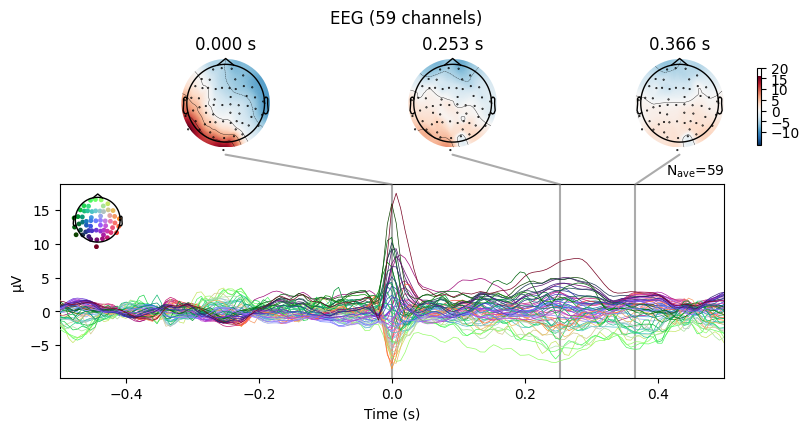

[<Figure size 800x420 with 6 Axes>, <Figure size 800x420 with 6 Axes>]

In [53]:
ecg_evoked = create_ecg_epochs(raw).average()
ecg_evoked.apply_baseline(baseline=(None, -0.2))
ecg_evoked.plot_joint()

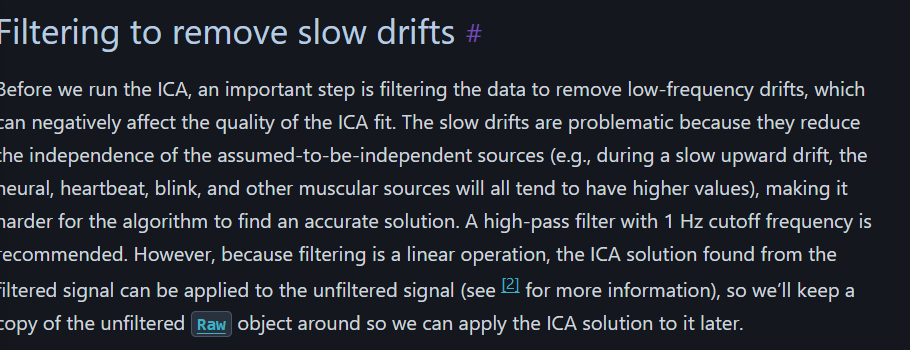

In [54]:
filt_raw=raw.copy().filter(l_freq=1.0,h_freq=None)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 497 samples (3.310 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


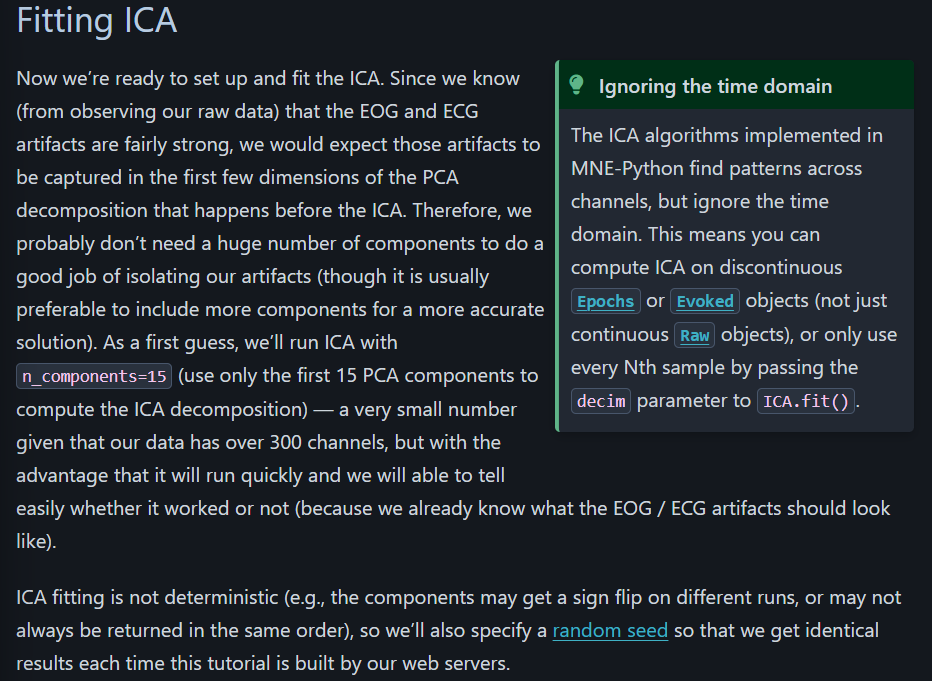

**Epochs** used for fitting ICA should not be baseline-corrected.Because cleaning the data via ICA may introduce DC offsets, we suggest to baseline correct your data after cleaning(and not before), should you require baseline correction.

In [55]:
ica=ICA(n_components=15,max_iter="auto",random_state=97)
ica.fit(filt_raw)
ica


Fitting ICA to data using 161 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.4s.


<ICA | raw data decomposition, method: fastica (fit in 22 iterations on 9010 samples), 15 ICA components (161 PCA components available), channel types: mag, eeg, no sources marked for exclusion>

# Looking at the ICA solution
Now we can examine the ICs to see what they captured.

Using get_explained_variance_ratio(), we can retrieve the fraction of variance in the original data that is explained by our ICA components in the form of a dictionary:


In [56]:
explained_var_ratio=ica.get_explained_variance_ratio(filt_raw)
for channel_type,ratio in explained_var_ratio.items():
   print(
        f"Fraction of {channel_type} variance explained by all components: " f"{ratio}"
    )

Fraction of mag variance explained by all components: 0.9358001342790973
Fraction of eeg variance explained by all components: 0.7798689203334389


The values were calculated for all ICA components jointly, but separately for each channel type (here: magnetometers and EEG).

We can also explicitly request for which component(s) and channel type(s) to perform the computation:

In [57]:
explained_var_ratio=ica.get_explained_variance_ratio(filt_raw,components=[0],ch_type="eeg")

In [58]:
explained_var_ratio["eeg"]

0.3250016627230523

In [59]:
explained_var_ratio = ica.get_explained_variance_ratio(
    filt_raw, components=[0], ch_type="eeg"
)
# This time, print as percentage.
ratio_percent = round(100 * explained_var_ratio["eeg"])
print(
    f"Fraction of variance in EEG signal explained by first component: "
    f"{ratio_percent}%"
)

Fraction of variance in EEG signal explained by first component: 33%


Creating RawArray with float64 data, n_channels=16, n_times=9010
    Range : 6450 ... 15459 =     42.956 ...   102.954 secs
Ready.


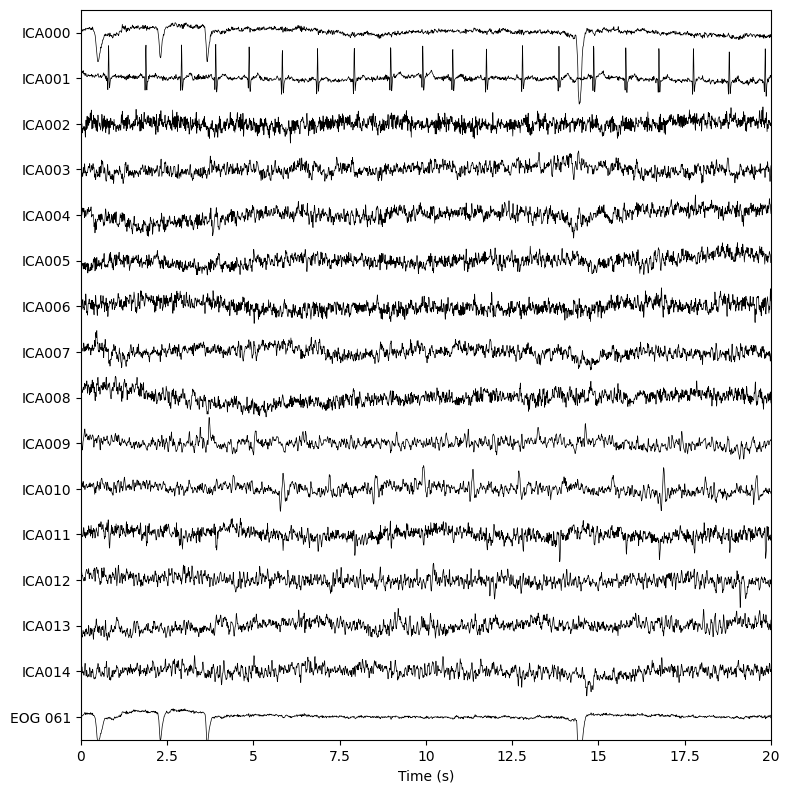

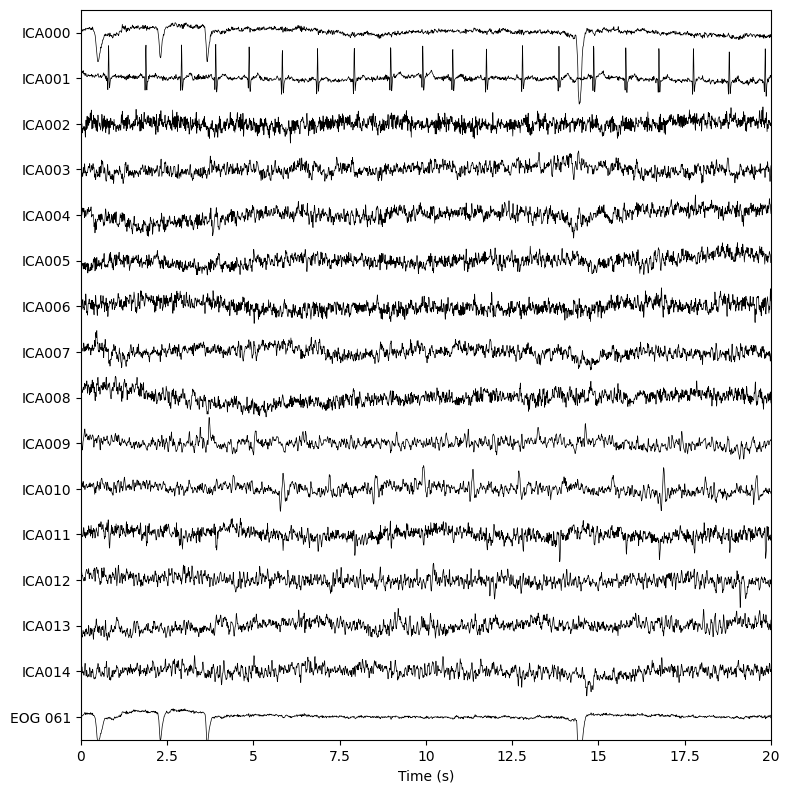

In [60]:
raw.load_data()
ica.plot_sources(raw,show_scrollbars=False)

 We can also visualize the scalp field distribution of each component using plot_components

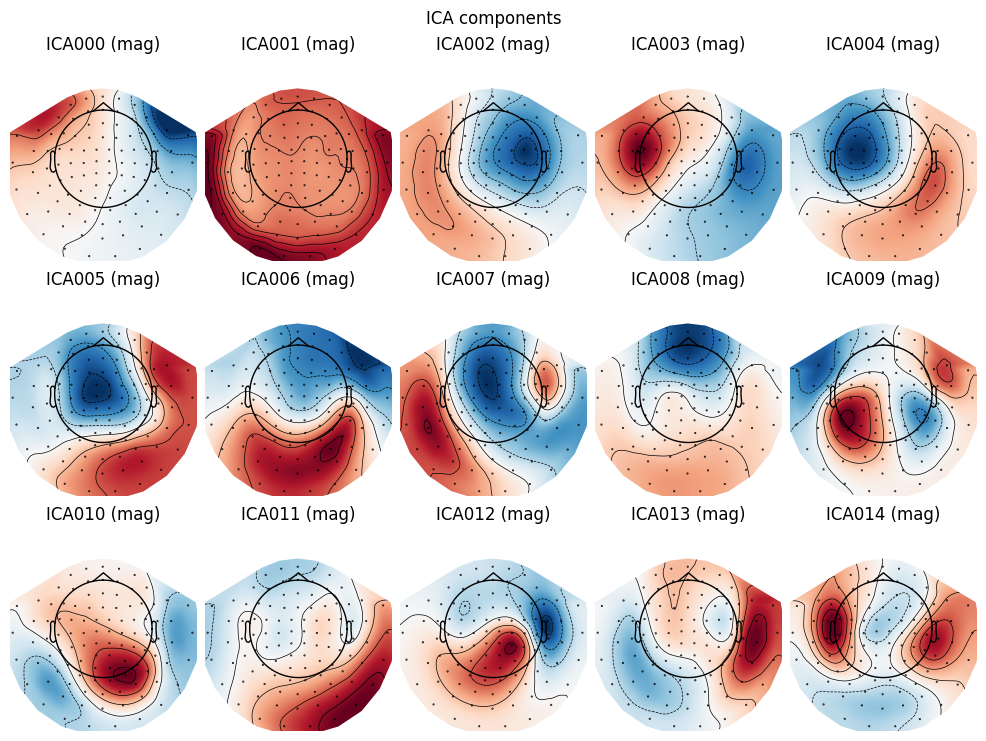

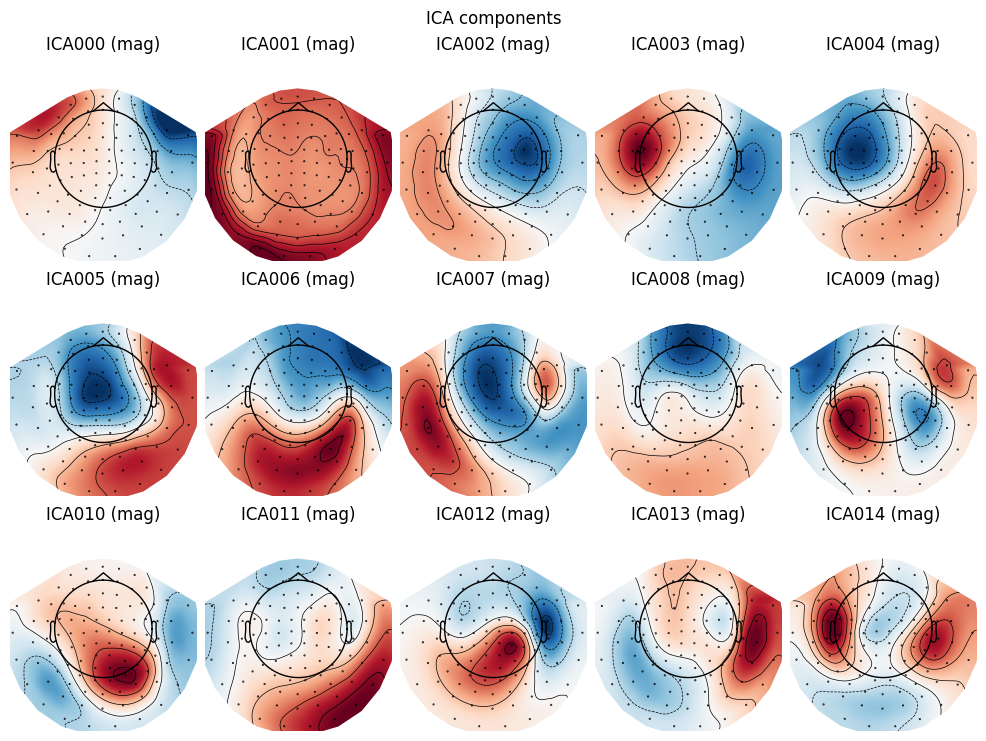

In [61]:
ica.plot_components()

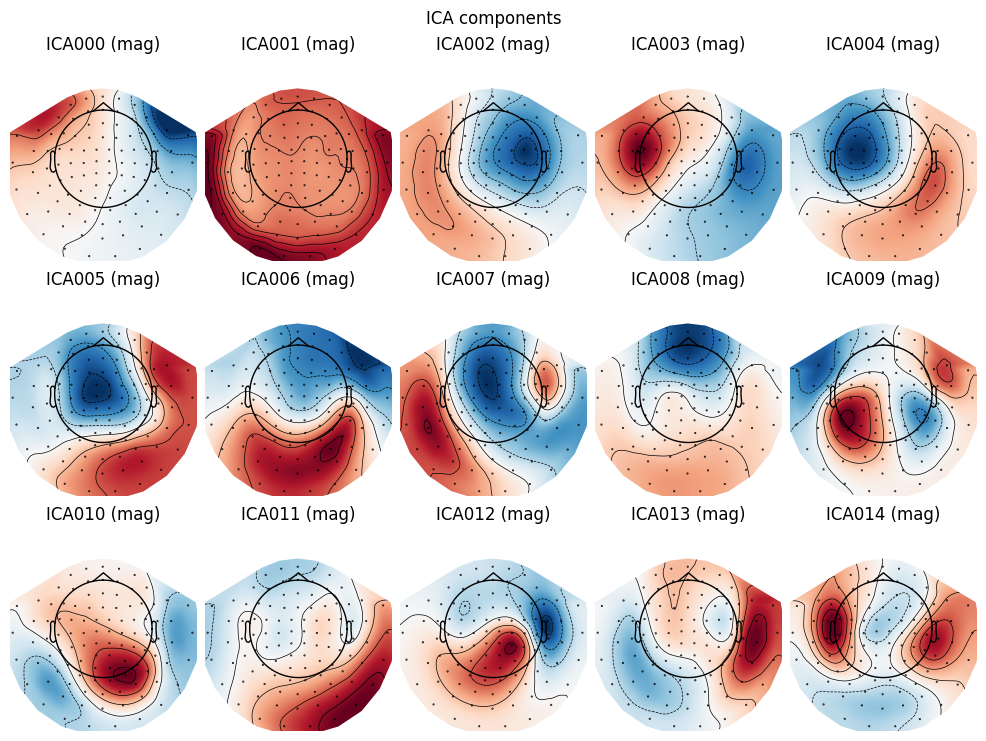

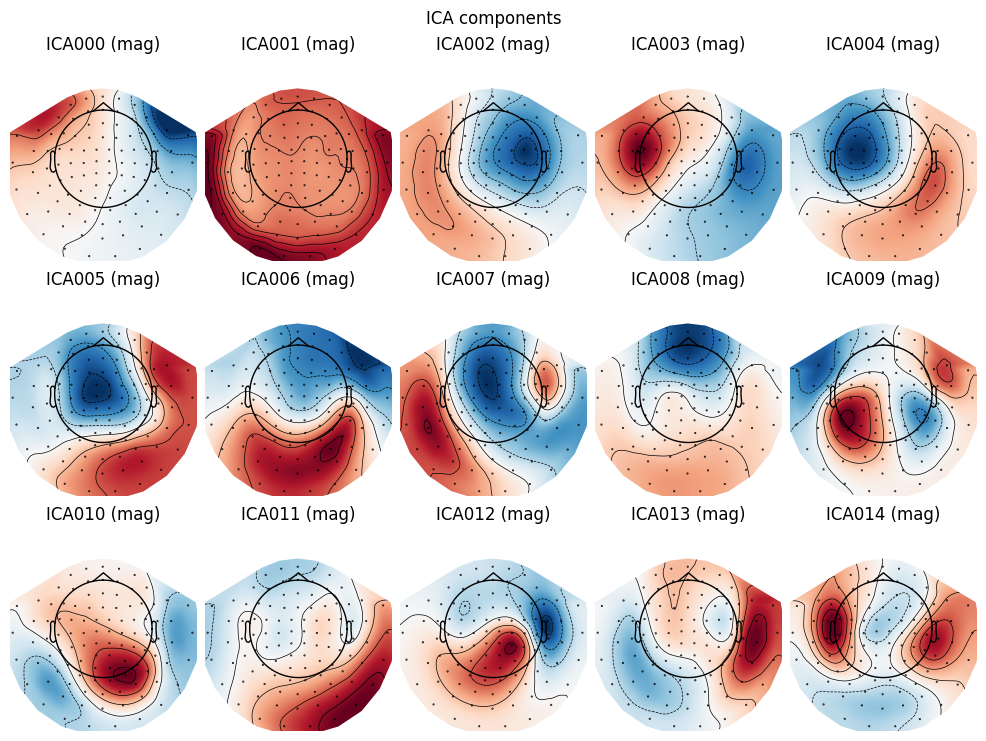

In [62]:
ica.plot_components(inst=raw)

In the plots above it’s fairly obvious which ICs are capturing our EOG and ECG artifacts, but there are additional ways visualize them anyway just to be sure. First, we can plot an overlay of the original signal against the reconstructed signal with the artifactual ICs excluded, using plot_overlay:

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 161 PCA components


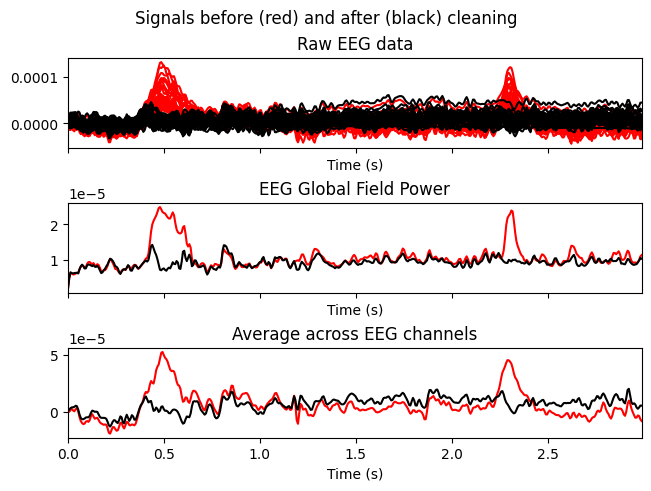

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 161 PCA components


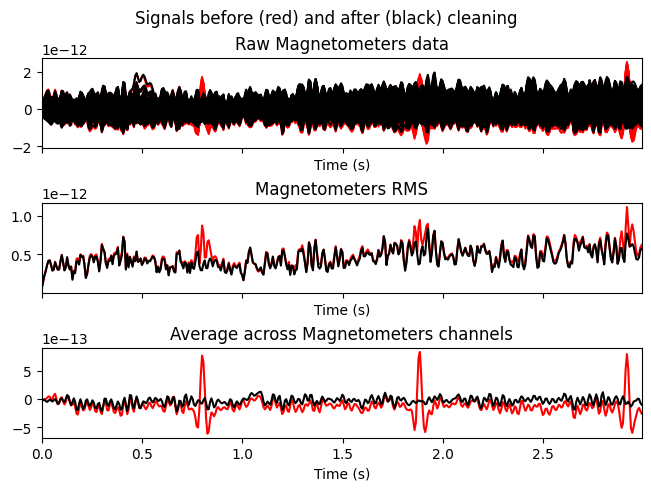

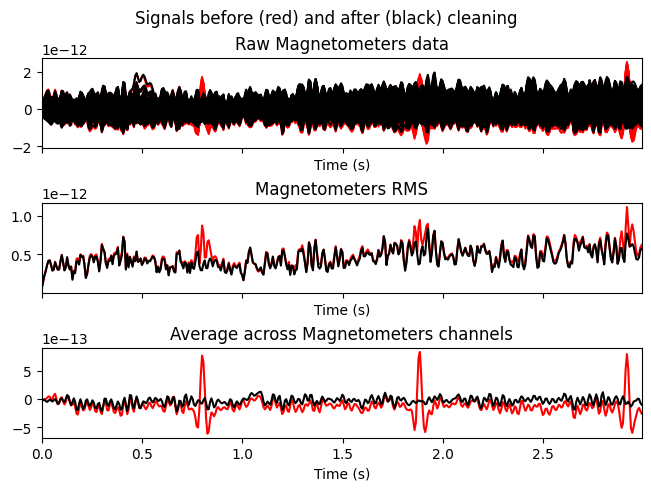

In [63]:
# blinks
ica.plot_overlay(raw,exclude=[0],picks="eeg")
ica.plot_overlay(raw,exclude=[1],picks="mag")

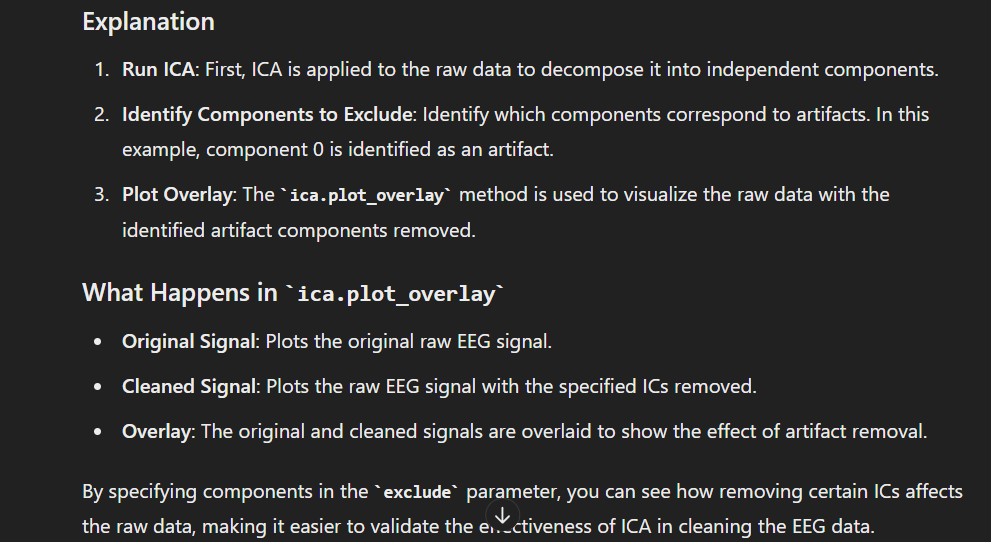

We can also plot some diagnostics of each IC using plot_properties
ica.plot_properties(raw,picks=[0,1])

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated


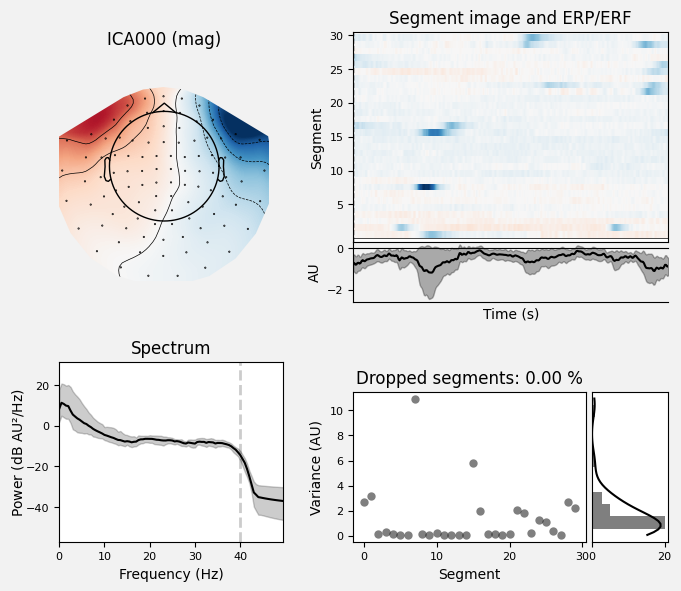

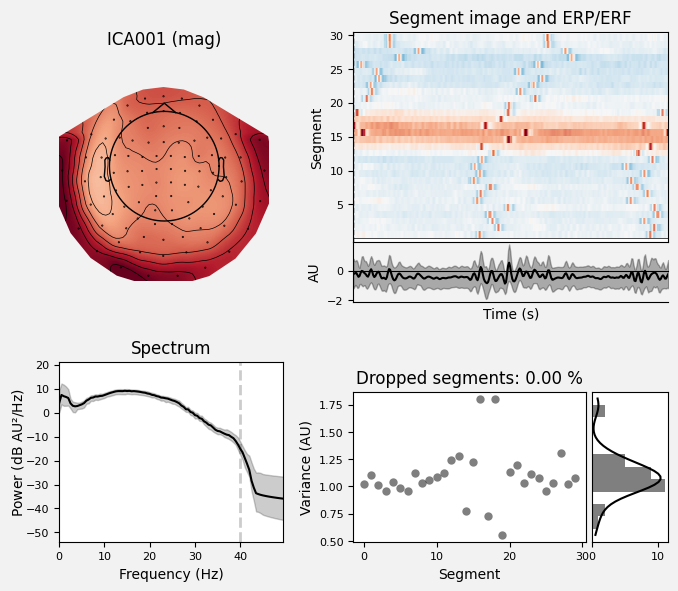

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [64]:
ica.plot_properties(raw,picks=[0,1])

Once we’re certain which components we want to exclude, we can specify that manually by setting the ica.exclude attribute. Similar to marking bad channels, merely setting ica.exclude doesn’t do anything immediately (it just adds the excluded ICs to a list that will get used later when it’s needed). Once the exclusions have been set, ICA methods like plot_overlay will exclude those component(s) even if no exclude parameter is passed, and the list of excluded components will be preserved when using mne.preprocessing.ICA.save and mne.preprocessing.read_ica


In [71]:
ica.exclude = [0, 1]  # indices chosen based on various plots above

In [66]:
len(artifact_picks)

21

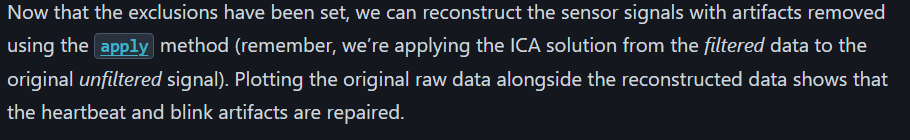

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 161 PCA components


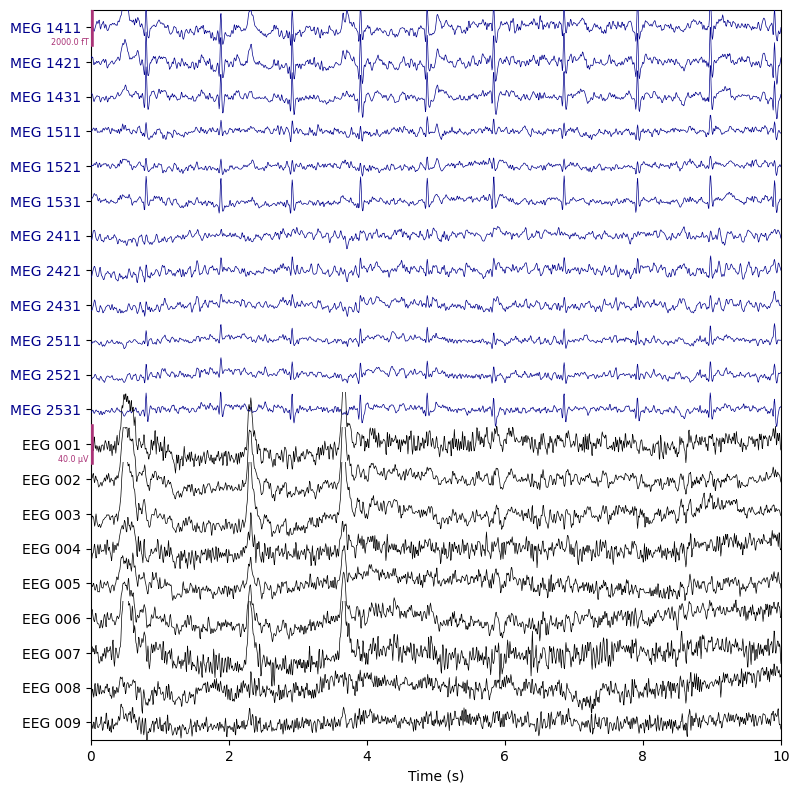

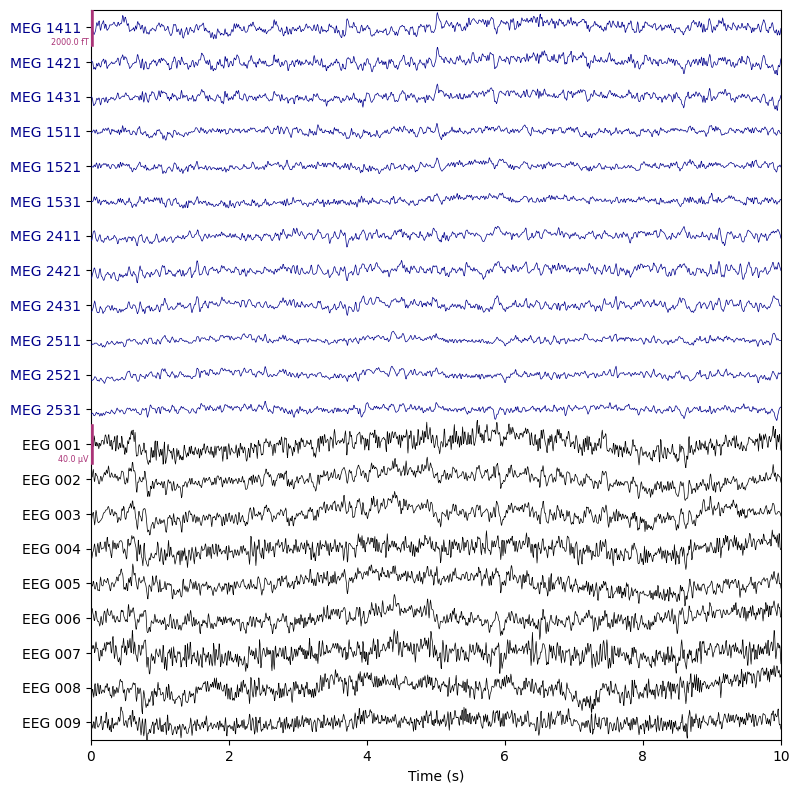

In [72]:
# ica.apply() changes the Raw object in-place, so let's make a copy first:
reconst_raw = raw.copy()
ica.apply(reconst_raw)

raw.plot(order=artifact_picks, n_channels=len(artifact_picks), show_scrollbars=False)
reconst_raw.plot(
    order=artifact_picks, n_channels=len(artifact_picks), show_scrollbars=False
)
del reconst_raw